In [1]:
#import modules
import pandas as pd
import numpy as np
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import random
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer

C:\Users\mmvdb\AppData\Local\Temp\ipykernel_22676\2454472113.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


(12645, 316)
(12645, 316)
(12645, 316)


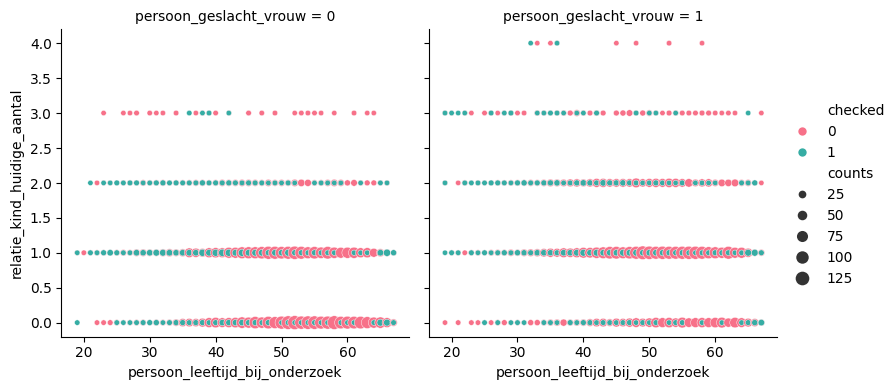

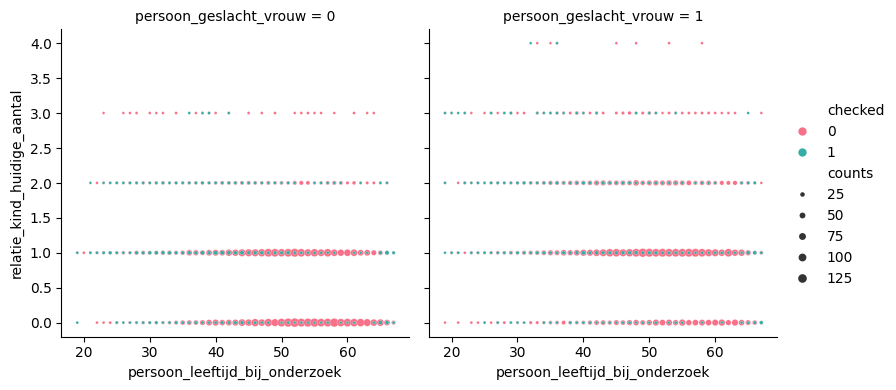

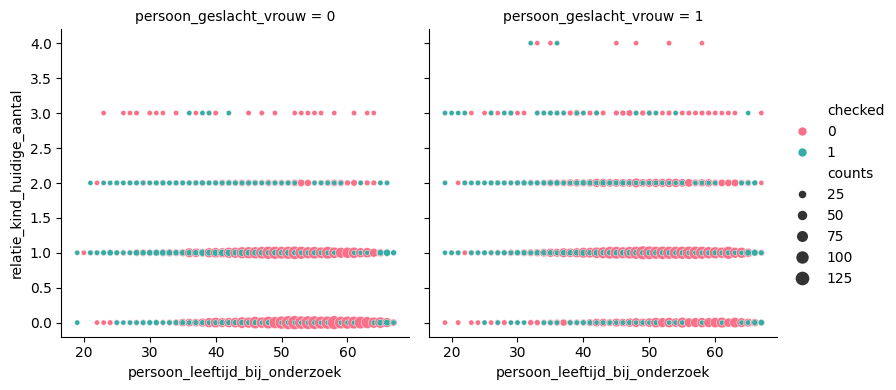

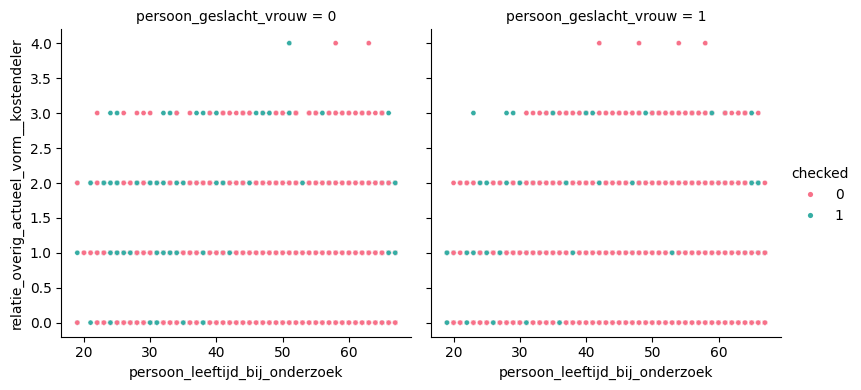

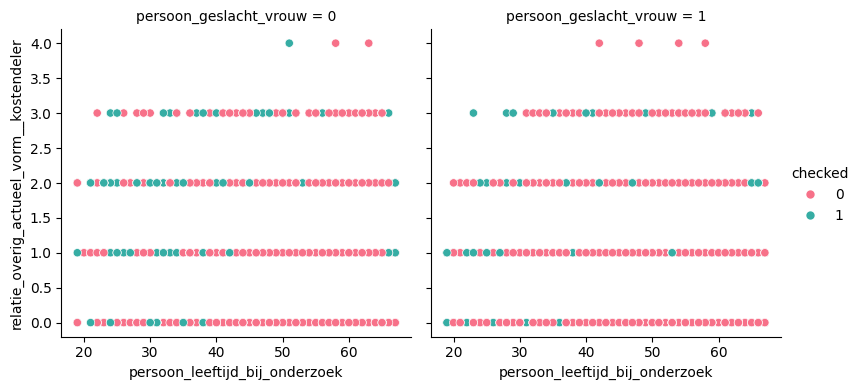

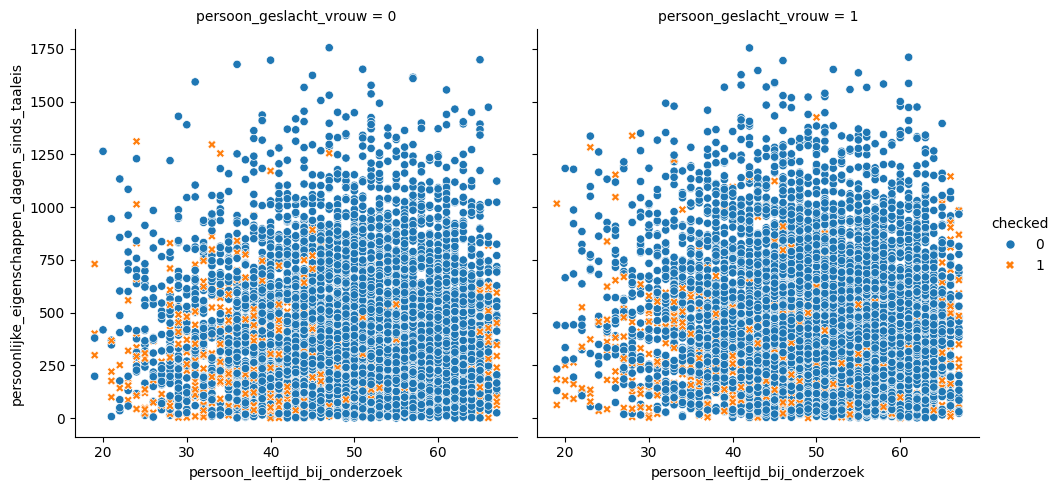

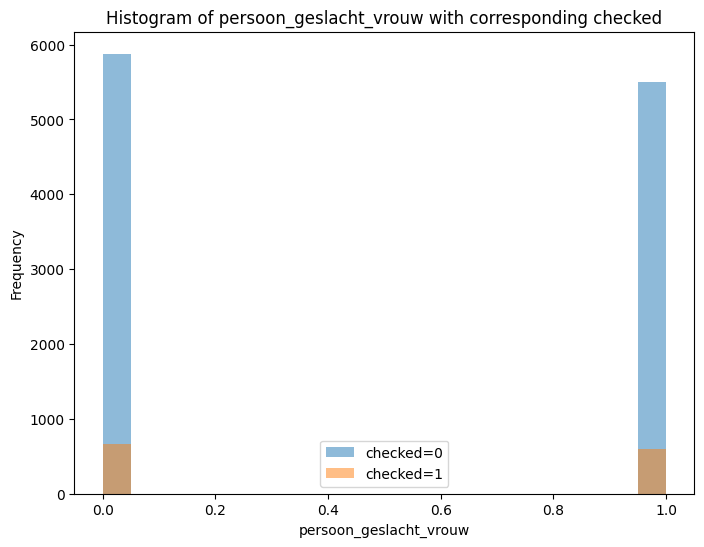

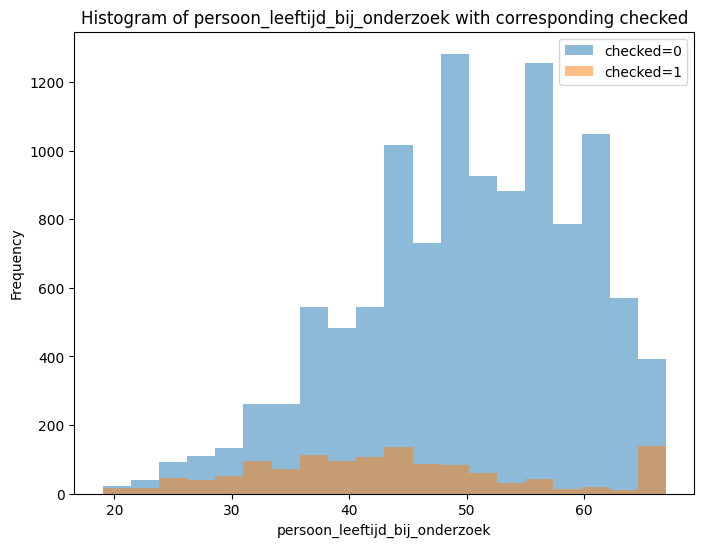

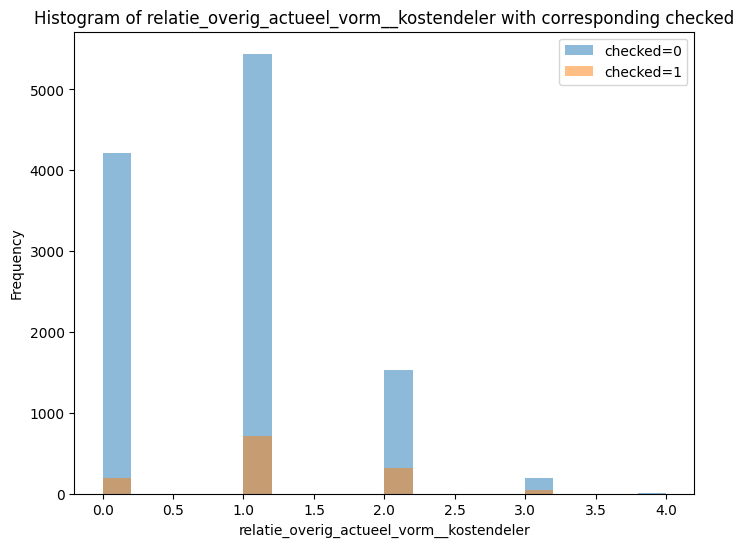

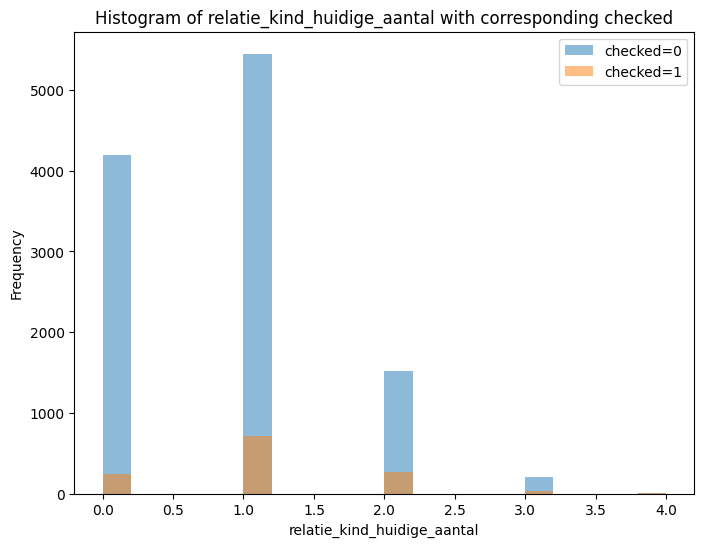

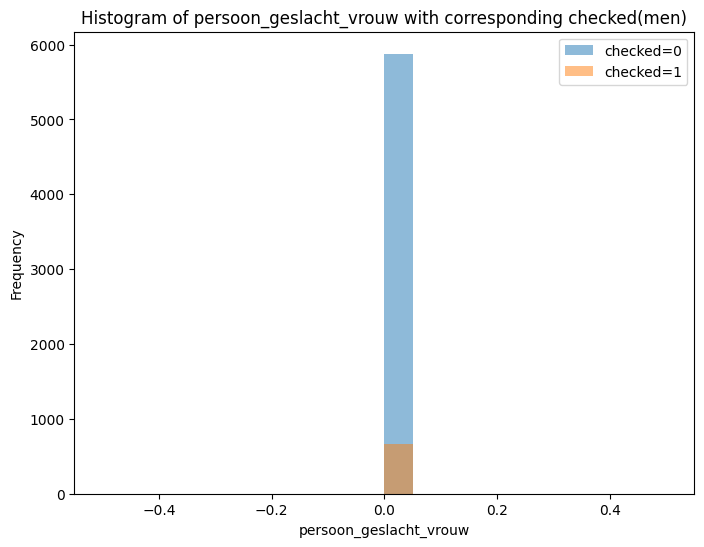

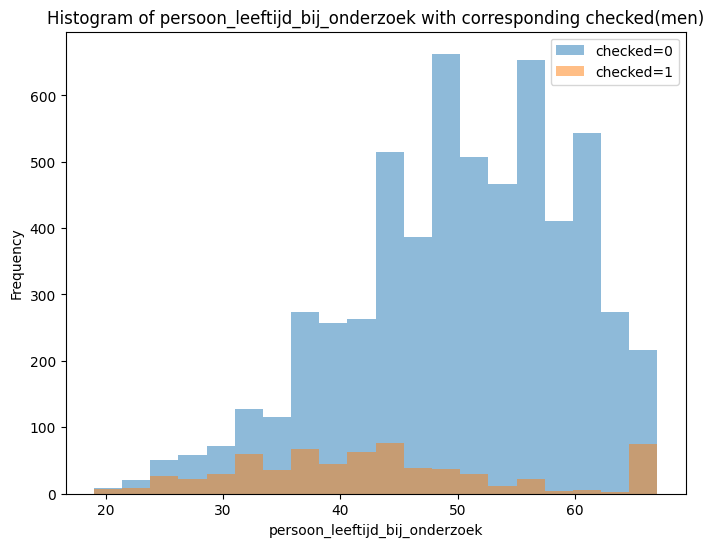

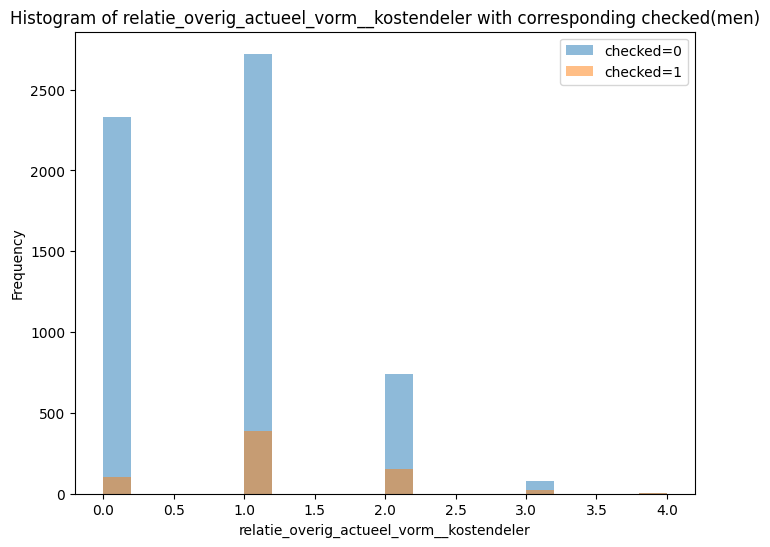

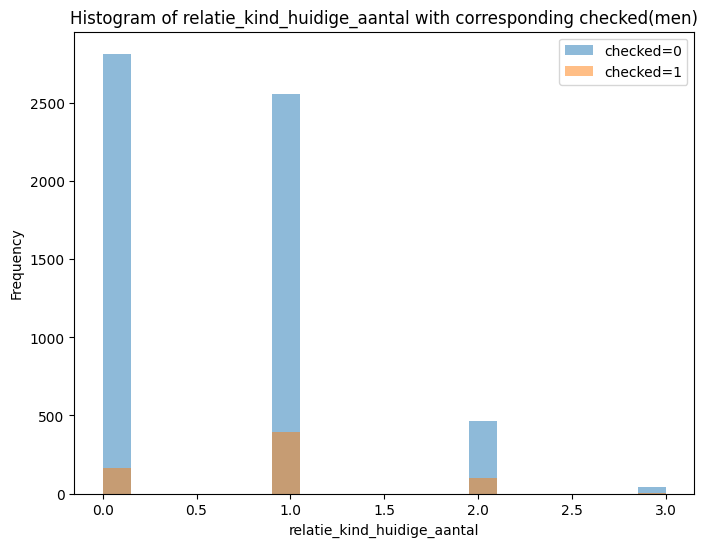

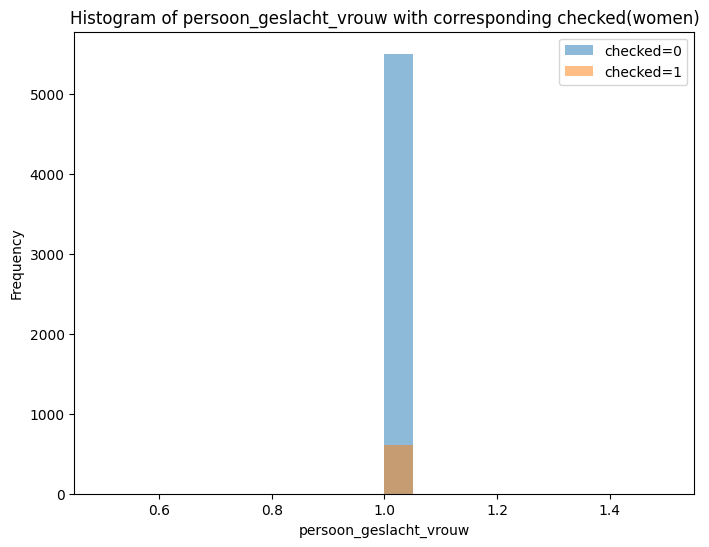

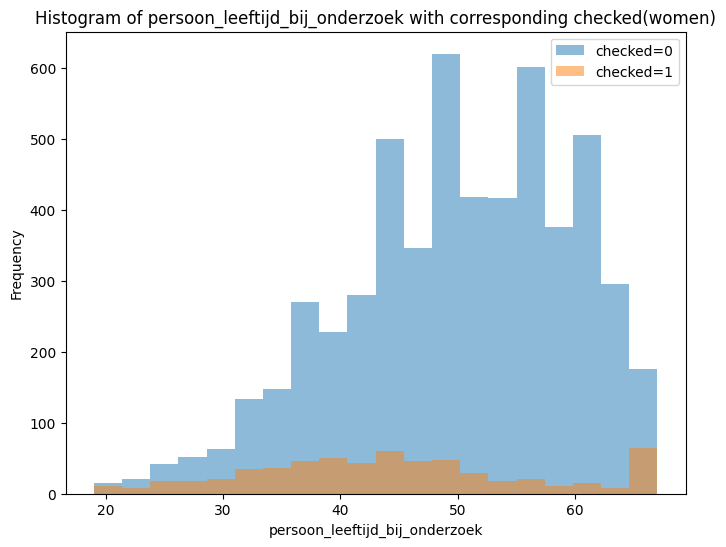

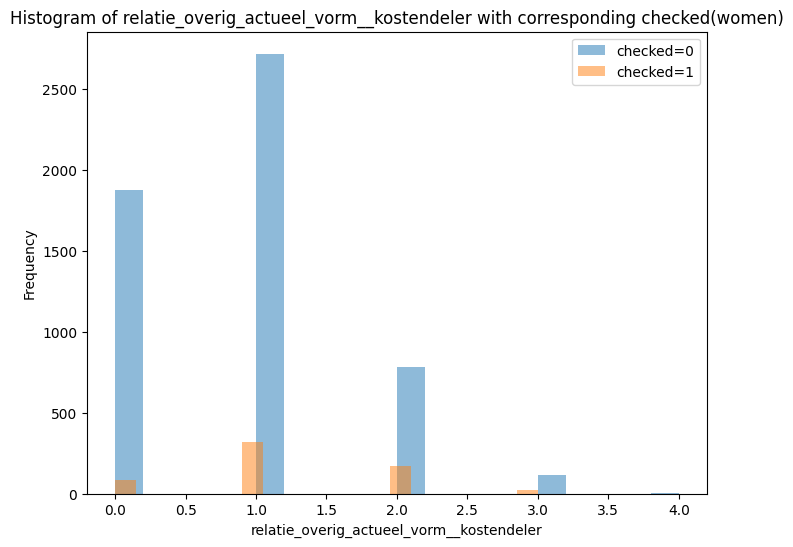

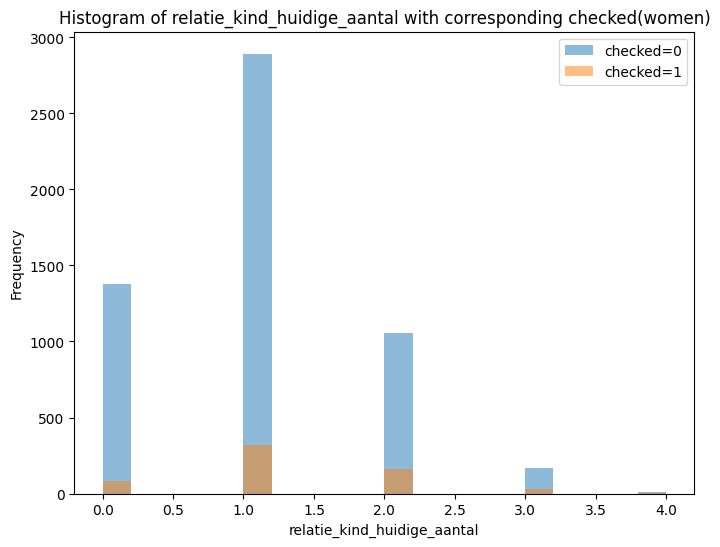

In [45]:
data = pd.read_csv('data/synth_data_for_training.csv')
features_to_pass = data.columns.tolist()
X = data
y = data['checked']
print(X.shape)
#count the number of times a combination of persoon_leeftijd_bij_onderzoek and relatie_kind_huidige_aantal occurs
X_grouped = X.groupby(['persoon_leeftijd_bij_onderzoek', 'relatie_kind_huidige_aantal', 'checked', 'persoon_geslacht_vrouw']).size().reset_index(name='counts')
print(X.shape)

sns.relplot(
    data=X_grouped,
    x="persoon_leeftijd_bij_onderzoek",
    y="relatie_kind_huidige_aantal",
    col="persoon_geslacht_vrouw",
    hue="checked",
    palette="husl",
    kind="scatter",
    height=4,
    aspect=1,
    facet_kws=dict(sharex=False),
    size="counts",  # Use a column that has unique values for each entry
    sizes=(15, 100),  # Adjust the size range as desired
)


sns.relplot(
    data=X_grouped,
    x="persoon_leeftijd_bij_onderzoek",
    y="relatie_kind_huidige_aantal",
    col="persoon_geslacht_vrouw",
    hue="checked",
    palette="husl",
    kind="scatter",
    height=4,
    aspect=1,
    facet_kws=dict(sharex=False),
    size="counts",  # Use a column that has unique values for each entry
    sizes=(4, 40),  # Adjust the size range as desired
)

sns.relplot(
    data=X_grouped,
    x="persoon_leeftijd_bij_onderzoek",
    y="relatie_kind_huidige_aantal",
    col="persoon_geslacht_vrouw",
    hue="checked",
    palette="husl",
    kind="scatter",
    height=4,
    aspect=1,
    facet_kws=dict(sharex=False),
    size="counts",  # Use a column that has unique values for each entry
    sizes=(14, 100),  # Adjust the size range as desired
)

sns.relplot(
    data=X,
    x="persoon_leeftijd_bij_onderzoek",
    y="relatie_overig_actueel_vorm__kostendeler",
    col="persoon_geslacht_vrouw",
    hue="checked",
    palette="husl",
    kind="scatter",
    height=4,
    aspect=1,
    facet_kws=dict(sharex=False),
    size="checked",  # Add the size parameter
    sizes=(14, 14),  # Adjust the size range as desired
)

sns.relplot(
    data=X,
    x="persoon_leeftijd_bij_onderzoek",
    y="relatie_overig_actueel_vorm__kostendeler",
    col="persoon_geslacht_vrouw",
    hue="checked",
    palette="husl",  # Adjust color palette as desired
    kind = 'scatter',
    height=4, # Adjust height of each subplot
    aspect=1, # Adjust aspect ratio of each subplot
    facet_kws=dict(sharex=False), # Avoid sharing x-axis
)

#What is 'dagen sinds taaleis', feature handbook says it is an important feature. 
sns.relplot(
    data=X,
    x="persoon_leeftijd_bij_onderzoek", 
    y="persoonlijke_eigenschappen_dagen_sinds_taaleis", 
    col= "persoon_geslacht_vrouw",
    hue="checked", 
    style="checked"
)

# Select features and corresponding labels
selected_features = ['persoon_geslacht_vrouw', 'persoon_leeftijd_bij_onderzoek', 
                     'relatie_overig_actueel_vorm__kostendeler', 'relatie_kind_huidige_aantal']  # Replace with your feature names
label_column = 'checked'  # Replace with your label column name
print(data.shape)
# Plot histograms for selected features
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    for label_value in data[label_column].unique():
        plt.hist(data[data[label_column] == label_value][feature], bins=20, alpha=0.5, label=f'{label_column}={label_value}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature} with corresponding {label_column}')
    plt.legend()
    plt.show()

data_men = data[data['persoon_geslacht_vrouw'] == 0] 
data_women = data[data['persoon_geslacht_vrouw'] == 1]  

for feature in selected_features:
    plt.figure(figsize=(8, 6))
    for label_value in data[label_column].unique():
        plt.hist(data_men[data_men[label_column] == label_value][feature], bins=20, alpha=0.5, label=f'{label_column}={label_value}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature} with corresponding {label_column}(men)')
    plt.legend()
    plt.show()

for feature in selected_features:
    plt.figure(figsize=(8, 6))
    for label_value in data[label_column].unique():
        plt.hist(data_women[data_women[label_column] == label_value][feature], bins=20, alpha=0.5, label=f'{label_column}={label_value}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature} with corresponding {label_column}(women)')
    plt.legend()
    plt.show()

# Plot histograms for men and women against age

# 1. Descriptive Statistics
#print(data.describe())

# 2. Data Visualization
#sns.pairplot(data)  # Example of pairplot for visualization

# 3. Correlation Analysis
#correlation_matrix = data.corr()
#print((correlation_matrix['persoon_geslacht_vrouw'].sort_values())[-20::])
#correlation_matrix = data.corr()
#print((correlation_matrix['persoon_geslacht_vrouw'].sort_values())[::20])


#plt.figure(figsize=(10, 8))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
#plt.title('Correlation Heatmap')
#plt.show()

# 4. Group Comparisons
#group_comparison = data.groupby('group_column')
#print(group_comparison.mean())




In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
import random


def get_ngbr(sub_data, knn, dataset, subindex):
    #dataset = sub_data
    rand_sample_id = random.randrange(0, len(sub_data))
    #print(subindex)
    #print(subindex[rand_sample_id])
    #print(Dataset.iloc[rand_sample_id])
    parent = sub_data.iloc[rand_sample_id].to_frame().T
    ngbrs = knn.kneighbors(parent, 2)[1][0]
    
    parent = dataset.iloc[subindex[rand_sample_id]].to_frame().T
    c1, c2 = dataset.iloc[subindex[ngbrs[0]]], dataset.iloc[subindex[ngbrs[1]]]
    #print(sub_data)
    #parent = dataset.iloc[rand_sample_id]
    return parent, c1, c2

def generate_balanced_dataset(x_train, y_train, p_attrs, cl, targetLabel, targetAttr, ageTransformer):
    
    dataset = x_train
    dataset["checked"] = y_train
    


    ageTransformer = ageTransformer.fit(x_train)
    X_transformed = ageTransformer.transform(x_train)
    ageName = ageTransformer.named_transformers_['binned'].get_feature_names_out()
    colnames = ageTransformer.named_transformers_['remainder'].get_feature_names_out()
    colnames = np.append(ageName, colnames)
    
    transformed_dataset = pd.DataFrame(X_transformed, columns=colnames)
    transformed_dataset = transformed_dataset.reindex(sorted(transformed_dataset.columns), axis=1)
    transformed_dataset['checked'] = y_train
    
    standardizer = StandardScaler()
    standardizer = standardizer.fit(transformed_dataset)
    
    # Step 1: Count the number of samples in each group
    count_groups = get_count(transformed_dataset, p_attrs, cl, targetLabel, targetAttr)
    max_size = max(count_groups.values())
    # Step 2: Set oversampling parameters
    cr, f = 0.8, 1.0  # User-defined values for controlling oversampling

    # Step 3: Iterate over each class label and protected attribute
    for c in cl:
        for attr in p_attrs:
            print("iterating")
            # Step 4: Get subgroup data
            #df.loc[df['column_name'] == some_value]
            #sib = Dataset.loc[Dataset[targetLabel] == some_value]

            sub_data = transformed_dataset[(transformed_dataset[targetLabel] == c) & (transformed_dataset[targetAttr] == attr)]
            subindex = sub_data.index
            sub_group_size = count_groups[(c, attr)]
            to_generate = max_size - sub_group_size
            #print(sub_data)
            # Step 5: Apply k-nearest neighbors to find neighbors
            #normalizer = Normalizer.fit(sub_data)
            #sub_data = normalizer.transform(sub_data)
            sub_data = pd.DataFrame(standardizer.transform(sub_data), columns=dataset.columns)

            knn = NearestNeighbors().fit(sub_data)

            # Step 6: Generate new samples to balance the dataset
            for i in range(to_generate):
                parent, c1, c2 = get_ngbr(sub_data, knn, dataset, subindex)
                new_candidate = {}

                #Step 7: Iterate over columns and generate new values
                for col in dataset.columns:
                    if parent[col].dtype == bool:
                        if cr > random.randrange(0, 1):
                            new_val = random.choice([parent[col], c1[col], c2[col]])
                        else:
                            new_val = parent[col]
                    elif parent[col].dtype == object:  # String
                        new_val = random.choice([parent[col], c1[col], c2[col]])
                    else:  # Numeric
                        if cr > random.randrange(0, 1):
                            #Needs fixing-------------------------------
                            #new_val = parent[col] + f * (c1[col] - c2[col])
                            new_val = random.choice([parent[col], c1[col], c2[col]])
                        else:
                            new_val = parent[col]
                    new_candidate[col] = new_val
                    #print(new_candidate)

                #Step 8: Add new candidate to the dataset
                #Dataset = Dataset.append(new_candidate, ignore_index=True)
                dataset = pd.concat([dataset, pd.DataFrame(new_candidate, columns=dataset.columns)], ignore_index=True)
                #final_df = pd.concat([df, augmented_df], ignore_index=True)

    return dataset


def get_count(Dataset, p_attrs, cl, targetLabel, targetAttr):
    sub_counts = {}
    
    for i in range(len(cl)):
        for j in range(len(p_attrs)):
            subgrp = Dataset[(Dataset[targetLabel] == cl[i]) & (Dataset[targetAttr] == p_attrs[j])]
            sub_counts[cl[i], p_attrs[j]] = len(subgrp)
    return sub_counts

In [4]:
def augment(X_train, y_train):

    ageTransformer = ColumnTransformer(
        transformers=[
            ("binned",  KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), ['persoon_leeftijd_bij_onderzoek'])
        ]
        ,remainder='passthrough'  # This means that the remaining columns will be left as they are
    )
    cl = [0, 1]
    p_attrs = [0, 1, 2, 3, 4]

    targetLabel = "checked"
    targetAttr = "persoon_leeftijd_bij_onderzoek"
    new_data = generate_balanced_dataset(X_train, y_train, p_attrs, cl, targetLabel, targetAttr, ageTransformer)
    y_train = new_data['checked']
    X_train = new_data.drop(['checked'], axis=1)
    
    return(X_train, y_train)



In [49]:
data = pd.read_csv('data/synth_data_for_training.csv')
features_to_pass = data.columns.tolist()
X = data.drop(['checked'], axis=1)
y = data['checked']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(len(features_to_pass))

#Age is also removed as it is binned first
features_to_delete = ['competentie_vakdeskundigheid_toepassen', 'pla_historie_ontwikkeling', 'afspraak_inspanningsperiode',
                     'afspraak_laatstejaar_aantal_woorden', 'afspraak_aantal_woorden', 'afspraak_signaal_voor_medewerker',
                     'persoonlijke_eigenschappen_uitstroom_verw_vlgs_klant', 'persoonlijke_eigenschappen_taaleis_voldaan',
                    'competentie_kwaliteit_leveren', 'competentie_gedrevenheid_en_ambitie_tonen',
                     'persoonlijke_eigenschappen_opstelling', 'competentie_overtuigen_en_beïnvloeden', 'competentie_aansturen',
                     'competentie_other', 'competentie_op_de_behoeften_en_verwachtingen_van_de__klant__richten', 'persoonlijke_eigenschappen_houding_opm',
                     'competentie_materialen_en_middelen_inzetten', 'persoonlijke_eigenschappen_leergierigheid_opm', 'competentie_formuleren_en_rapporteren',
                     'persoonlijke_eigenschappen_initiatief_opm', 'competentie_onderzoeken', 'persoonlijke_eigenschappen_presentatie_opm',
                     'competentie_met_druk_en_tegenslag_omgaan', 'persoonlijke_eigenschappen_communicatie_opm', 'persoonlijke_eigenschappen_doorzettingsvermogen_opm',
                     'competentie_instructies_en_procedures_opvolgen', 'competentie_leren', 'competentie_omgaan_met_verandering_en_aanpassen',
                     'persoonlijke_eigenschappen_flexibiliteit_opm', 'persoonlijke_eigenschappen_zelfstandigheid_opm', 'checked']
print(len(features_to_delete))
#elements of features_to_delete but not of features_to_pass
print(([x for x in features_to_delete if x not in features_to_pass]))
print(len(features_to_pass) - len(features_to_delete))
features_to_pass = [x for x in features_to_pass if x not in features_to_delete]
print(len(features_to_pass))


316
31
[]
285
285


In [50]:
from sklearn.preprocessing import KBinsDiscretizer
# Define a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("binned",  KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), ['persoon_leeftijd_bij_onderzoek']),
        ('passthrough', 'passthrough', features_to_pass)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# PICK CLASSIFIER FROM BEFORE 
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

# PIPELINE CREATION
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('classification', classifier)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
original_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the original model: ', original_accuracy)
#number of features used in pipeline model
print(len(pipeline.named_steps['preprocessor'].transformers_[1][2]))


def convert_dataframe_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue

        t = FloatTensorType([None, 1])

        inputs.append((k, t))
    return inputs

initial_inputs = convert_dataframe_schema(X)

# Let's convert the model to ONNX
onnx_model = convert_sklearn(
    pipeline, initial_types=initial_inputs,
    target_opset=12)

inputs = {c: X_test[c].values for c in X_test.columns}
for (c, _) in initial_inputs:
    inputs[c] = inputs[c].astype(np.float32)
for k in inputs:
    inputs[k] = inputs[k].reshape((inputs[k].shape[0], 1))

# Let's check the accuracy of the converted model
sess = rt.InferenceSession(onnx_model.SerializeToString())
#inputs = {c: X_test[c].values for c in X_test.columns}
y_pred_onnx =  sess.run(None, inputs)

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)


c:\Users\mmvdb\.virtualenvs\onnx-example-main-_mYDYLfU\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


Accuracy of the original model:  0.939595192915876
285
Accuracy of the ONNX model:  0.939595192915876
